# **Minería de tópicos**
Basado en el artículo *Python for NLP: Topic Modeling* por Usman Malik https://stackabuse.com/python-for-nlp-topic-modeling/.  

El propósito de esta sección es obtener tópicos de los tweets recabados acerca del Asalto al Capitolio de los Estados Unidos.

## Importación de Bibliotecas

In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import urllib3
from bs4 import BeautifulSoup
from googlesearch import search


### Función "Interprete" de Tópicos


Busca en Google las palabras de cada tópico para obtener el título del primer resultado.

El cual es posteriormente asigna al tópico como referencia.



In [27]:
def googler(busqueda):
    http = urllib3.PoolManager()
    response = search(busqueda, num_results = 10)
    #Fetch
    for result in response:
        result = http.request('GET', result)
        soup = BeautifulSoup(result.data,'html.parser')
        if type(soup.title) != type(None):
            return soup.title.string
    return soup.title.string


### Función Minería de Tópicos Non-Negative Matrix Factorization


Antes aplicar el algoritmo de NMF es necesario obtener el vocabulario del archivo

NMF hace uso de TFIDF

max_df=0.80 -> Palabras que aparezcan al menos en 80% del documento



In [28]:
"""
Función que aplica Non-Negative Matrix Factorización al contenido de los tweets.
Almacena en un archivo un resumen con las palabras top de cada tópico.
@param   reviews_datasets_NMF  dataframe que contiene una columna 'data__text', la cual se refiere al texto
                               extraido del tweet
@return  reviews_datasets_NMF  dataframe original con una columna extra que denota el tópico al que pertenece
"""
def txt_NMF(reviews_datasets_NMF):
    """
    Antes aplicar el algoritmo de NMF es necesario obtener el vocabulario del archivo
    NMF hace uso de TFIDF
    max_df=0.80 -> Palabras que aparezcan al menos en 80% del documento
    min_df=2 -> Palabras que aparezcan al menos en 2 documentos
    """
    my_stop_words=text.ENGLISH_STOP_WORDS.union(["https"],["nhttps"],["d4leu57x7h"])
    tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words)
    ##Matriz generada con TFIDF
    doc_term_matrix = tfidf_vect.fit_transform(reviews_datasets_NMF['data__text'].values.astype('U'))
    """
    Uso de NMF para crear temas junto con la distribución de probabilidad para cada palabra del vocabulario
    n_components:5 -> Numero de categorias o temas que en las que queremos
                        que se divida nuestro texto
    random_state:42 -> seed 
    Creamos una matriz de probabilidad con las probabilidades de todas las palabras en el vocabulario
    """
    nmf = NMF(n_components=5, random_state=42)
    nmf.fit(doc_term_matrix )

  
    """
    ###Palabras de nuestro vocabulario
    for i in range(10):
        random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
        print(tfidf_vect.get_feature_names()[random_id])
    """
    ##Para encontrar el primer topic se usa "components_" con atributo 0
    first_topic = nmf.components_[0]
    ##first_topic contiene la probabilidad de 3716 palabras para el topic 1
    ##Ordenamos los índices de acuerdo a los valores de las probabilidades
    ##Regresa indíces de 10 palabras con las probabilidades más altas
    top_topic_words = first_topic.argsort()[-10:]
    """
    Pasamos índices al vector para observar las palabras
    
    for i in top_topic_words:
        print(tfidf_vect.get_feature_names()[i])
    """
    fic = open("topics_NMF.txt", "w")
    print('\t\t\t\tTemas NMF', file=fic)
    for i,topic in enumerate(nmf.components_):
        print(f'NMF Top 10 words for topic #{i}:', file=fic)
        print(f'NMF Top 10 words for topic #{i}:')
        words_tpc = [tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]]
        article_title = googler(' '.join(words_tpc))
        print(words_tpc, file=fic)
        print(words_tpc)
        print(article_title, file=fic)
        print(article_title)
        print('\n\n', file=fic)
        print('\n\n')
    fic.close()

    topic_values = nmf.transform(doc_term_matrix)
    reviews_datasets_NMF['Topic'] = topic_values.argmax(axis=1)
    print(reviews_datasets_NMF.head())
    return reviews_datasets_NMF

### Función Minería de Tópicos Latent Dirichlet Allocation

In [35]:
"""
Función que aplica Latent Dirichlet Allocation al contenido de los tweets.
Almacena en un archivo un resumen con las palabras top de cada tópico.
@param   reviews_datasets_LDA  dataframe que contiene una columna 'data__text', la cual se refiere al texto
                               extraido del tweet
@return  reviews_datasets_LDA  dataframe original con una columna extra que denota el tópico al que pertenece
"""
def txt_LDA(reviews_datasets_LDA):
    """
    Antes aplicar el algoritmo de LDA es necesario obtener el vocabulario
    del archivo
    max_df=0.80 -> Palabras que aparezcan al menos en 80% del documento
    min_df=2 -> Palabras que aparezcan al menos en 2 documentos
    """
    my_stop_words=text.ENGLISH_STOP_WORDS.union(["https"],["nhttps"],["d4leu57x7h"])
    count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=my_stop_words)
    doc_term_matrix = count_vect.fit_transform(reviews_datasets_LDA['data__text'].values.astype('U'))

    """
    Uso de LDA para crear temas junto con la distribución de probabilidad 
    para cada palabra del vocabulario
    n_components:5 -> Numero de categorias o temas que en las que queremos
                        que se divida nuestro texto
    random_state:42 -> seed 
    """
    LDA = LatentDirichletAllocation(n_components=5, random_state=42)
    LDA.fit(doc_term_matrix)
    """
    for i in range(10):
        random_id = random.randint(0,len(count_vect.get_feature_names()))
        print(count_vect.get_feature_names()[random_id])
    """

    """
    Encontramos 10 palabras con la probabilidad más alta para los temas
    first_topic contiene las probabilidades de 3716 palabras para el tema 1
    argsort() Ordenar índices de acuerdo a los valores de probabilidades
    [-10:] Toma los últimos 10 valores, es decir los que tienen mayor valor  
    """
    first_topic = LDA.components_[0]
    #print(len(first_topic))
    top_topic_words = first_topic.argsort()[-10:]
    #print(top_topic_words)

    """
    Obtenemos palabras relacionadas con los índices anteriores
    
    for i in top_topic_words:
        print(count_vect.get_feature_names()[i])
    """
    
    """
    Impresion de 10 palabras con mayor probabilidad de cada uno de los 5 temas 
    """
    fic = open("topics_LDA.txt", "w")
    print('\t\t\t\tTemas LDA', file=fic)
    for i,topic in enumerate(LDA.components_):
        words_tpc = [count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]]
        article_title = googler(' '.join(words_tpc))
        print(f'LDA Top 10 words for topic #{i}:', file=fic)
        print(words_tpc, file=fic)
        print(article_title, file=fic)
        print('\n\n', file=fic)
        print(f'LDA Top 10 words for topic #{i}:')
        print(words_tpc)
        print(article_title)
        print('\n\n')
    fic.close()

    """
    Agregamos una columna al archivo donde agreguemos el tema al que pertenece
    """
    topic_values = LDA.transform(doc_term_matrix)
    topic_values.shape
    reviews_datasets_LDA['Topic'] = topic_values.argmax(axis=1)
    print(reviews_datasets_LDA.head())
    return reviews_datasets_LDA

### Importación de Datos y Análisis Exploratorio

In [36]:
reviews_datasets = pd.read_csv(r'Tweets Recabados.csv',engine='python')

In [37]:
reviews_datasets.shape

(2428, 3)

El data frame consiste en una tabla de 2428 registros (2428 tweets) con 3 columnas.  
Para visualizar las columnas mostramos una parte del dataframe

In [38]:
reviews_datasets

,data__id,data__lang,data__text
0,1347495838839238657,en,@PapaGlider @Jessica26307123 @MontyBoa99 @real...
1,1347495838688440320,en,US Capitol: Police confirms death of officer i...
2,1347495838063284230,en,@HookRocky @NBCNews @NBCNewsTHINK At least we ...
3,1347495834833747969,en,Mike Pompeo Says Capitol Riot Proves U.S. Isn'...
4,1347495834439606272,en,US Capitol Attack: President Trump Can�t Handl...
...,...,...,...
2423,1347561137278119936,en,Uh oh. Maybe they should�ve worn masks? \n\nI ...
2424,1347561136690843649,und,??\n\nhttps://t.co/FprykuE9bN
2425,1347561136242126849,en,Oregon representative allowed protesters into ...
2426,1347561136187727873,en,@realDonaldTrump The 5 deaths ARE ALL ON YOUR ...


Probamos si el dataframe contiene registros vacios.
En caso de tenerlos, es necesario eliminarlos

In [39]:
reviews_datasets.isnull().values.any()

False

Dado que no tiene registros nulos, es posible aplicar los algoritmos de modelado de tópicos LDA y NMF.  
Cuando se aplican los algoritmos se imprimen las palabras top de cada tópico en cada algorimo, y son almacenadas en archivos de texto para su consula posterior.

### Minado de tópicos

In [40]:
reviews_datasets_LDA = txt_LDA(reviews_datasets)
print('\n\n\n\n')
reviews_datasets_NMF = txt_NMF(reviews_datasets)

LDA Top 10 words for topic #0:
['died', 'donald', 'just', 'make', 'know', 'president', 'police', 'building', 'trump', 'people']
US Capitol riot: Police officer dies amid pressure on Trump over inciting violence - BBC News



LDA Top 10 words for topic #1:
['antifa', 'insurrection', 'riot', 'coup', 'attack', 'police', 'people', 'supporters', 'amp', 'trump']
The far right is falsely blaming antifa for the pro-Trump insurrection on Capitol Hill - Vox



LDA Top 10 words for topic #2:
['hill', 'trump', 'white', 'people', 'blm', 'terrorist', 'building', 'riots', 'riot', 'attack']
False equivalency between Black Lives Matter and Capitol siege: Experts, advocates  - ABC News



LDA Top 10 words for topic #3:
['insurrection', 'metal', 'took', 'storming', 'right', 'going', 'people', 'just', 'police', 'trump']
Capitol Insurrection Updates : NPR



LDA Top 10 words for topic #4:
['protests', 'siege', 'guard', 'national', 'officer', 'job', 'attack', 'inside', 'trump', 'police']
How a String of Fai

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF Top 10 words for topic #0:
['donald', '2021', 'january', 'make', 'heard', 'peacefully', 'soon', 'voices', 'marching', 'patriotically']
Fact Check: Did Trump Say to 'Peacefully and Patriotically' March to the Capitol?



NMF Top 10 words for topic #1:
['antifa', 'mob', 'did', 'violence', 'just', 'stormed', 'supporters', 'people', 'amp', 'trump']
Fact check: Men who stormed Capitol identified by Reuters are not undercover Antifa as posts claim | Reuters



NMF Top 10 words for topic #2:
['mo', 'lead', 'paul', 'organizer', 'gosar', 'andy', 'biggs', 'job', 'inside', 'attack']
Paul Gosar, Andy Biggs credited in video with organizing Trump crowd in DC



NMF Top 10 words for topic #3:
['investigation', 'realdonaldtrump', 'murder', 'pro', 'confirms', 'injured', 'riot', 'death', 'officer', 'police']
Trump riots: FBI to investigate death of policeman Brian Sicknick - BBC News



NMF Top 10 words for topic #4:
['know', 'coup', 'taking', 'act', 'coming', 'committing', 'security', 'skirting', 

El resultado de la ejecución de los algoritmos es el datagrame orginal más la columna Topic, que indica el número de tópico al que se relaciona el tweet.

In [47]:
reviews_datasets_LDA

,data__id,data__lang,data__text,Topic
0,1347495838839238657,en,@PapaGlider @Jessica26307123 @MontyBoa99 @real...,1
1,1347495838688440320,en,US Capitol: Police confirms death of officer i...,3
2,1347495838063284230,en,@HookRocky @NBCNews @NBCNewsTHINK At least we ...,1
3,1347495834833747969,en,Mike Pompeo Says Capitol Riot Proves U.S. Isn'...,1
4,1347495834439606272,en,US Capitol Attack: President Trump Can�t Handl...,1
...,...,...,...,...
2423,1347561137278119936,en,Uh oh. Maybe they should�ve worn masks? \n\nI ...,3
2424,1347561136690843649,und,??\n\nhttps://t.co/FprykuE9bN,0
2425,1347561136242126849,en,Oregon representative allowed protesters into ...,2
2426,1347561136187727873,en,@realDonaldTrump The 5 deaths ARE ALL ON YOUR ...,1


In [48]:
reviews_datasets_NMF

,data__id,data__lang,data__text,Topic
0,1347495838839238657,en,@PapaGlider @Jessica26307123 @MontyBoa99 @real...,1
1,1347495838688440320,en,US Capitol: Police confirms death of officer i...,3
2,1347495838063284230,en,@HookRocky @NBCNews @NBCNewsTHINK At least we ...,1
3,1347495834833747969,en,Mike Pompeo Says Capitol Riot Proves U.S. Isn'...,1
4,1347495834439606272,en,US Capitol Attack: President Trump Can�t Handl...,1
...,...,...,...,...
2423,1347561137278119936,en,Uh oh. Maybe they should�ve worn masks? \n\nI ...,3
2424,1347561136690843649,und,??\n\nhttps://t.co/FprykuE9bN,0
2425,1347561136242126849,en,Oregon representative allowed protesters into ...,2
2426,1347561136187727873,en,@realDonaldTrump The 5 deaths ARE ALL ON YOUR ...,1


# Clasificación de Posturas
Basado en el cuaderno Multi-class text classification (TFIDF) de Selene Reyes. Disponible en https://www.kaggle.com/selener/multi-class-text-classification-tfidf

### Importación de bibliotecas y datos

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [51]:
# Los tweets para entrenamiento y pruebas se encuentran en el directorio
# StanceTweetLabeled. Listamos el directorio para verificar que se encuentran
# cargados.
import os
print(os.listdir("./StanceTweetLabeled"))

['test.csv', 'train.csv']


In [52]:
# Importando datos
df_train = pd.read_csv('./StanceTweetLabeled/train.csv' , engine='python')
df_test = pd.read_csv('./StanceTweetLabeled/test.csv' , engine='python')
print("Forma de df_train:",df_train.shape)
print("Forma de df_test:",df_test.shape)

Forma de df_train: (2914, 5)
Forma de df_test: (1956, 5)


El dataset original tiene divididos los datos en datos de prueba y datos de entrenamiento. Vamos a combinarlos en uno sólo debido a que posteriormente dividiremos a los datos aplicando validación cruzada.

In [53]:
df = df_train.append(df_test)
df.shape

(4870, 5)

### Análisis de datos exploratorio

In [54]:
# Impresión de las primeras 2 filas para conocer su estructura
df.head(2)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos


La columna "Target" se refiere al tópico del tweet.
Para conocer cuales son estos podemos obtener sus valores únicos.

In [55]:
df["Target"].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement',
       'Donald Trump'], dtype=object)

De forma similar para la columna "Stance", que se refiere a la postura que la
 persona toma con respecto a cierto tópico u argumento.

In [56]:
df["Stance"].unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

Las columnas que interesan para el entrenamiento son "Tweet" y "Stance", pues a a partir de cierto tweet, queremos predecir la postura que viene implicita en el mismo. No consideramos la columna "Target" debido a que ninguno de los tópicos del dataset está relacionado con el asunto del Asalto al Capitolio de Estados Unidos 2021.  
Para ello se crea un nuevo dataframe con sólo estas dos columnas.

In [57]:
# Creación de un nuevo dataframe con sólo dos columnas
df1 = df[['Stance', 'Tweet']].copy()

Los tipos de posturas son AGAINST, FAVOR, NONE. Los autores del dataset colocan
a la postura NONE para aquellos tweets que no tienen que ver con los tópicos que ellos eligieron (Hilary Clinton, Legalization of Abortion, etc), así que para este caso de estudio es mejor omitir todos los tweets clasificados con esta postura.  
Primero contamos cuantos tweets hay por cada postura.

In [58]:
df1.groupby('Stance').Tweet.count()

Stance
AGAINST    2409
FAVOR      1205
NONE       1256
Name: Tweet, dtype: int64

Se tienen 1256 tweets clasificados como NONE. Se eliminarán todos estos para quedar con sólo tweets de AGAINST y FAVOR.  
Para ello los ordenamos por postura y nos quedamos con los primeros 3614 registros, debido a que es lo que se obtiene de restarle el número de tweets NONE al total de tweets. (4870 - 1256)

In [59]:
df1 = df1.sort_values(by=['Stance']).head(3614)
df1

,Stance,Tweet
0,AGAINST,"@tedcruz And, #HandOverTheServer she wiped cle..."
2727,AGAINST,RT @AdvocatesOfLife: RT @ProLifeYouth Adopting...
2728,AGAINST,On my bday I'm always so grateful to my bio pa...
2729,AGAINST,That's like being into cannibalism but against...
2731,AGAINST,It should never ever be legal to have an abort...
...,...,...
1226,FAVOR,Excited to hear author @LeoraTanenbaum Slut-S...
1006,FAVOR,"If we do not act, we will be the generation wh..."
1630,FAVOR,@realDonaldTrump Favorites and retweets keep p...
1003,FAVOR,If sea levels get any higher flooding in lowla...


Los diferentes valores de la columna "Stance" se tratarán como clases. Se trata entonces de un problema de dos clases. Se necesita representar a cada clase (postura) como números para que el modelo predictivo pueda entenderlas.

In [60]:
# Creando una nueva columna llamada 'stance_id' con las posturas codificadas
df1['stance_id'] = df1['Stance'].factorize()[0]
stance_id_df = df1[['Stance', 'stance_id']].drop_duplicates()

# Diccionarios para mapear entre el identificador de la postura y la postura
stance_to_id = dict(stance_id_df.values)
id_to_stance = dict(stance_id_df[['stance_id', 'Stance']].values)

print("Impresión de los diccionarios creados")
print("stance_to_id:",stance_to_id)
print("id_to_stance:",id_to_stance)

Impresión de los diccionarios creados
stance_to_id: {'AGAINST': 0, 'FAVOR': 1}
id_to_stance: {0: 'AGAINST', 1: 'FAVOR'}


In [61]:
# Impresión de un subconjunto aleatorio del nuevo dataframe
df1.sample(n=4)

,Stance,Tweet,stance_id
686,AGAINST,@HillaryforNH will u rope off the people too H...,0
1373,FAVOR,If we have equality women wouldn't be expected...,1
1259,FAVOR,@USAlivestrong @scottscameron @ljmljm55 @blond...,1
421,AGAINST,@ramzaruglia @a_man_in_yellow Just imagine all...,0


A continuación se muestra un gráfico con el número de de tweets por postura.

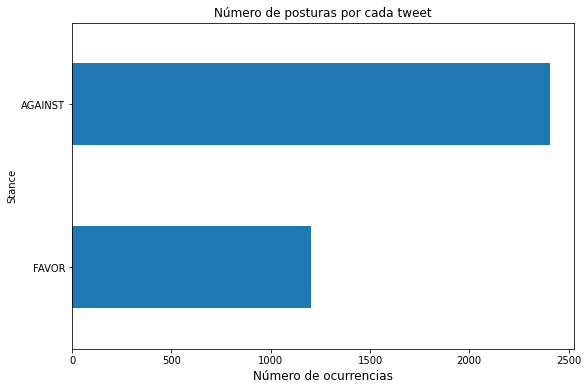

In [62]:
fig = plt.figure(figsize=(9,6),facecolor='white')
df1.groupby('Stance').Tweet.count().sort_values().plot.barh(
  ylim=0, title= 'Número de posturas por cada tweet')
plt.xlabel('Número de ocurrencias', fontsize = 12);

## Preprocesamiento del texto
Para este paso se transformarán los tweets a vectores de  $R^n$ para que el modelo pueda realizar predicciones. Para ello se utilizará TF-IDF.

In [63]:
# Se utiliza un escalamiento logaritmico
# Se remueven palabras que ocurren en menos de 5 documentos
# Se utilizan unigramas y bigramas
# Se remueven stop words en inglés
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# Se transforma cada tweet en un vector de TFIDF
features = tfidf.fit_transform(df1.Tweet).toarray()


# Se utilizan como etiquetas el identificador de la postura
labels = df1.stance_id

features.shape

(3614, 1413)

## Modelos de clasificación
En esta sección se entrenan tres modelos, y mediante validación cruzada de 5 iteraciones se obtendrá la exactitud de cada modelo. Aquel que tenga la mejor exactitud será el elegido como modelo para nuestro caso de estudio.  
Los modelos que se propone usar son:
- Categorical Naive Bayes
- Multinomial Naive Bayes
- Logistic Regression
- Random Forest
- Linear Support Vector Machine
- Non Linear Support Vector Machine

In [64]:
# Los modelos son almacenados en una lista
models = [
  RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
  MultinomialNB(),
  CategoricalNB(),
  LogisticRegression(random_state=0),
  LinearSVC(),
  SVC()
]

# Cross-validation de 5 iteraciones
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
# Se itera sobre la lista de modelos y en la lista entries se almacena
# el nombre del modelo y valores obtenidos de la validación cruzada.
# De la validación cruzada se almacena el identificador de la iteración y
# la exactitud obtenida en cada iteración.
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

# Creamos un nuevo dataframe a partir de la lista entries
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

En este momento se tiene el dataframe cv_df que contiene la lista de exactitudes obtenidas de la validación cruzada de cada modelo. Se tienen 5 valores distintos de exactitud por cada iteración.

In [65]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.680498
1,RandomForestClassifier,1,0.674965
2,RandomForestClassifier,2,0.670816
3,RandomForestClassifier,3,0.666667
4,RandomForestClassifier,4,0.668975
5,MultinomialNB,0,0.749654
6,MultinomialNB,1,0.726141
7,MultinomialNB,2,0.679115
8,MultinomialNB,3,0.656985
9,MultinomialNB,4,0.704986


Para decidir que modelo utilizar, se obtiene el promedio y desviación estándar de las exactitudes de cada modelo.

In [67]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

# Se crea un nuevo dataframe con el promedio y desviación estándar de la
# exactitud de cada modelo.
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean_Accuracy', 'Standard_deviation']
acc

,Mean_Accuracy,Standard_deviation
model_name,,
CategoricalNB,0.666574,0.000206
LinearSVC,0.673494,0.036347
LogisticRegression,0.692310,0.031642
MultinomialNB,0.703376,0.036753
RandomForestClassifier,0.672384,0.005460
SVC,0.688436,0.026901


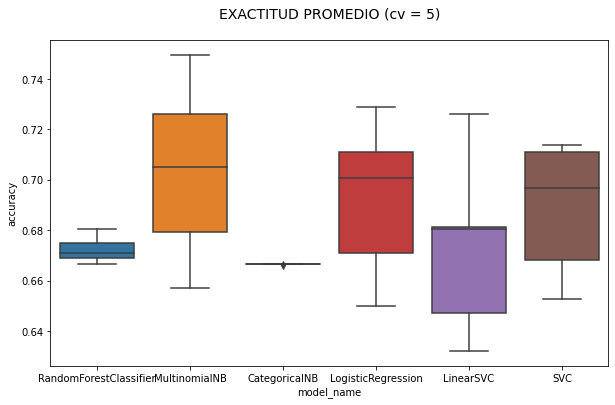

In [68]:
plt.figure(figsize=(10,6),facecolor='white')
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
plt.title("EXACTITUD PROMEDIO (cv = 5)\n", size=14);

Con el diagrama de cajas y vigotes se puede notar que el modelo con mejor exactitud promedio es Multinomial Naive Bayes. Otro aspecto a destacar es que todos los modelos poseen un rendimiento similar, de entre 0.65 y 0.7, así que el elegir entre uno u otro no varía demasiado. Para efectos de este trabajo, nos quedaremos con Multinomial Naive Bayes.

## Evaluación del modelo elegido

In [69]:
# Se divide los datos en datos de prueba y de entrenamiento
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, 
                                                                labels, 
                                                                df1.index, test_size=0.25, 
                                                                random_state=1)
# Se genera un modelo con los datos de entrenamiento obtenidos
model = MultinomialNB()
model.fit(X_train, y_train)
# Se evalúa con los datos de prueba
y_pred = model.predict(X_test)

### Precisión, exhaustividad y valor F

In [70]:
print('\t\t\tMÉTRICAS DE CLASIFICACIÓN\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1.Stance.unique()))

			MÉTRICAS DE CLASIFICACIÓN

              precision    recall  f1-score   support

     AGAINST       0.75      0.93      0.83       609
       FAVOR       0.73      0.37      0.49       295

    accuracy                           0.75       904
   macro avg       0.74      0.65      0.66       904
weighted avg       0.74      0.75      0.72       904



### Matríz de confusión
La matriz de confusión es una tabla que representa los valores reales y los valores predecidos. Un buen modelo es aquel que tiene colores oscuros en la diagonal.

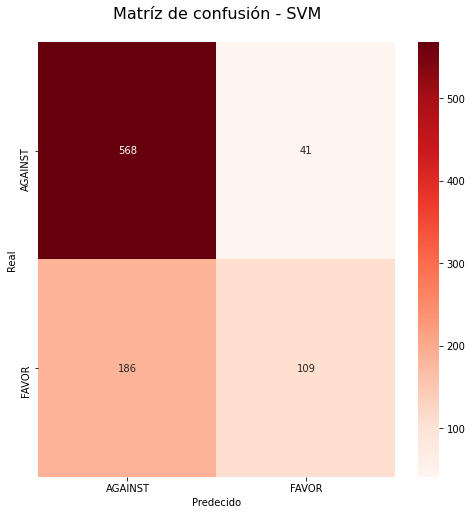

In [71]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8),facecolor='white')
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=stance_id_df.Stance.values, 
            yticklabels=stance_id_df.Stance.values)
plt.ylabel('Real')
plt.xlabel('Predecido')
plt.title("Matríz de confusión - SVM\n", size=16);

Con los datos observados se puede notar que el clasificador tiende a clasificar las posturas en "AGAINST". Esto probablemente se debe a la alta cantidad de registros que tiene esta clase con respecto a las demás.

In [72]:
df1.groupby('Stance').Tweet.count()

Stance
AGAINST    2409
FAVOR      1205
Name: Tweet, dtype: int64

In [73]:
df1.shape

(3614, 3)

### Corrección del modelo
Para tratar de solucionar esta desviación del modelo, eliminaremos 1204 registros clasificados como AGAINST, esto con el objetivo de que la cantidad de registros por cada clase este balanceada.

In [74]:
# Se ordena el dataframe por la columna Stance, lo que coloca los registros con
# el orden AGAINST, FAVOR, NONE.
# Posteriormente eliminaremos a los primeros 1204 registros, que son parte de
# AGAINST. Esto se hace seleccionando los últimos 2410 registros del dataframe.
# TOTAL_REGISTROS - REGISTROS A ELIMINAR = REGISTROS A MANTENER
# 3614 - 1204 = 2410
df_balanced = df1.sort_values(by=['Stance']).tail(2410)
df_balanced

,Stance,Tweet,stance_id
1516,AGAINST,@deanesmay The Command-and-control mentality r...,0
1525,AGAINST,@Ehsan_Kassim It's time we make the Housewares...,0
31,AGAINST,Jesus response to a religious environment was...,0
29,AGAINST,I still remember the days when I prayed God fo...,0
6,AGAINST,"Morality is not derived from religion, it prec...",0
...,...,...,...
788,FAVOR,"At what point do we rename summer ""The Rainy S...",1
655,FAVOR,Man: this is an issue and needs to be addresse...,1
664,FAVOR,What a great week for social issues #SCOTUS No...,1
900,FAVOR,I stand with @HillaryClinton I know she is for...,1


In [75]:
df_balanced.groupby('Stance').Tweet.count()

Stance
AGAINST    1205
FAVOR      1205
Name: Tweet, dtype: int64

Ahora que las clases están balanceadas, repetimos el proceso de preprocesamiento del texto y entrenamiento del modelo.

In [76]:
# Se transforma cada tweet en un vector de TFIDF
# Notar que ahora se utiliza el dataframe df_balanced
features = tfidf.fit_transform(df_balanced.Tweet).toarray()

# Se utilizan como etiquetas el identificador de la postura
labels = df_balanced.stance_id

In [77]:
# Se divide los datos en datos de prueba y de entrenamiento
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                labels,
                                                                df_balanced.index, test_size=0.25,
                                                                random_state=1)
# Se genera un modelo con los datos de entrenamiento obtenidos
model = MultinomialNB()
model.fit(X_train, y_train)
# Se evalúa con los datos de prueba
y_pred = model.predict(X_test)

In [78]:
print('\t\t\tMÉTRICAS DE CLASIFICACIÓN\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1.Stance.unique()))

			MÉTRICAS DE CLASIFICACIÓN

              precision    recall  f1-score   support

     AGAINST       0.71      0.76      0.73       288
       FAVOR       0.76      0.71      0.74       315

    accuracy                           0.73       603
   macro avg       0.74      0.74      0.73       603
weighted avg       0.74      0.73      0.73       603



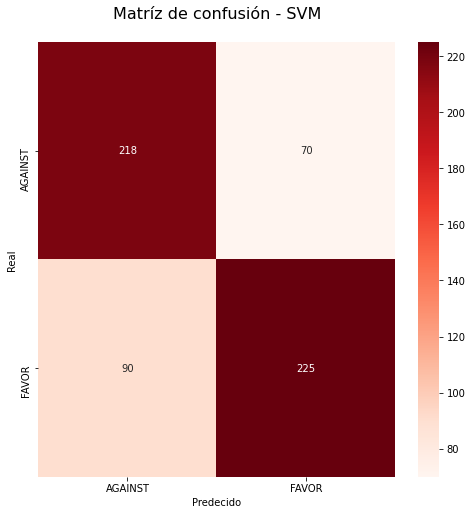

In [79]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8),facecolor='white')
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=stance_id_df.Stance.values, 
            yticklabels=stance_id_df.Stance.values)
plt.ylabel('Real')
plt.xlabel('Predecido')
plt.title("Matríz de confusión - SVM\n", size=16);

Se nota que esta vez la matriz de confusión ya tiene un patrón con color obscuro en la diagonal.  
Este modelo será el que finalmente utilizaremos.

## Predicción

In [80]:
X = df_balanced['Tweet'] # Datos de entrada
y = df_balanced['Stance'] # Variable a predecir

# TF-IDF aprende el vocabulario e idf de los datos de entrenamiento
# Es decir, se genera un "Vectorizador"
fitted_vectorizer = tfidf.fit(X)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X)

model = MultinomialNB().fit(tfidf_vectorizer_vectors, y)

Para la predicción creamos nuevos tweets que reflejen la postura de una persona. A continuación mostramos dos ejemplos.

In [81]:
new_tweet = """I don't think in that way"""
print(model.predict(fitted_vectorizer.transform([new_tweet])))

['AGAINST']


In [82]:
new_tweet = """She is right"""
print(model.predict(fitted_vectorizer.transform([new_tweet])))

['FAVOR']


# Clasificación de Posturas en Tweets sobre Asalto al Capitolio de Estados Unidos 2021
Para esta sección se buscará clasificar las posturas utilizando el modelo generado en la sección anterior.

In [83]:
# Utilizando el dataframe reviews_datasets_NMF se genera una nueva columna con
# el valor de la postura predecido por el modelo Multinomial Naive Bayes
tweets_stance_NMF = reviews_datasets_NMF.assign(
    Stance=lambda x: ( model.predict(fitted_vectorizer.transform(x['data__text'])))
)
tweets_stance_NMF

,data__id,data__lang,data__text,Topic,Stance
0,1347495838839238657,en,@PapaGlider @Jessica26307123 @MontyBoa99 @real...,1,FAVOR
1,1347495838688440320,en,US Capitol: Police confirms death of officer i...,3,AGAINST
2,1347495838063284230,en,@HookRocky @NBCNews @NBCNewsTHINK At least we ...,1,AGAINST
3,1347495834833747969,en,Mike Pompeo Says Capitol Riot Proves U.S. Isn'...,1,FAVOR
4,1347495834439606272,en,US Capitol Attack: President Trump Can�t Handl...,1,AGAINST
...,...,...,...,...,...
2423,1347561137278119936,en,Uh oh. Maybe they should�ve worn masks? \n\nI ...,3,FAVOR
2424,1347561136690843649,und,??\n\nhttps://t.co/FprykuE9bN,0,AGAINST
2425,1347561136242126849,en,Oregon representative allowed protesters into ...,2,FAVOR
2426,1347561136187727873,en,@realDonaldTrump The 5 deaths ARE ALL ON YOUR ...,1,AGAINST


In [84]:
# De forma similar, se genera una nueva columna para reviews_datasets_LDA
tweets_stance_LDA = reviews_datasets_LDA.assign(
    Stance=lambda x: ( model.predict(fitted_vectorizer.transform(x['data__text'])))
)

## Análisis de resultados

Podemos obtener la cantidad de tweets que se agruparon que tuvieron postura AGAINST y FAVOR

In [85]:
tweets_stance_NMF.groupby('Stance').data__id.count()

Stance
AGAINST    1293
FAVOR      1135
Name: data__id, dtype: int64

De igual forma la contidad de tweets en cada tópico

In [86]:
tweets_stance_NMF.groupby('Topic').data__id.count()

Topic
0     152
1    1650
2     175
3     322
4     129
Name: data__id, dtype: int64

Podemos también obtener los tweets que se agruparon en AGAINST y FAVOR tomando en cuenta el tópico en el que se agruparon.

In [87]:
print("Conteo de posturas por tópico LDA:")
print(tweets_stance_LDA.groupby(['Topic','Stance']).data__id.count())

Conteo de posturas por tópico LDA:
Topic  Stance 
0      AGAINST     87
       FAVOR       65
1      AGAINST    874
       FAVOR      776
2      AGAINST     85
       FAVOR       90
3      AGAINST    206
       FAVOR      116
4      AGAINST     41
       FAVOR       88
Name: data__id, dtype: int64


In [88]:
print("Conteo de posturas por tópico NMF:")
print(tweets_stance_NMF.groupby(['Topic','Stance']).data__id.count())

Conteo de posturas por tópico NMF:
Topic  Stance 
0      AGAINST     87
       FAVOR       65
1      AGAINST    874
       FAVOR      776
2      AGAINST     85
       FAVOR       90
3      AGAINST    206
       FAVOR      116
4      AGAINST     41
       FAVOR       88
Name: data__id, dtype: int64


A continuación tenemos un gráfico de barras que muestra de forma gráfica el número de posturas por tópico

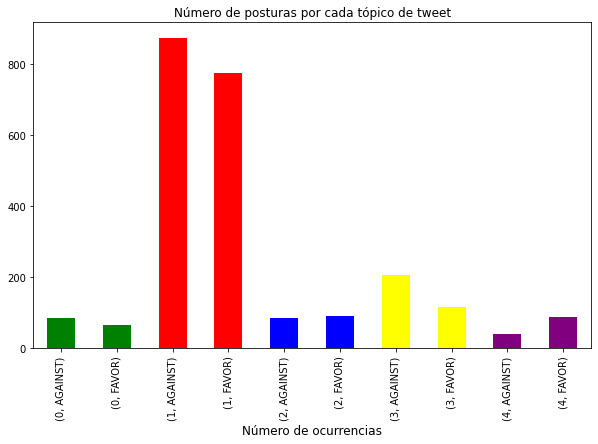

In [89]:
plt.figure(figsize=(10,6),facecolor='white')
tweets_stance_LDA.groupby(['Topic','Stance']).data__id.count().plot.bar(
  title= 'Número de posturas por cada tópico de tweet',
  color=['green', 'green', 'red', 'red', 'blue', 'blue', 
        'yellow', 'yellow', 'purple', 'purple']
)
plt.xlabel('Número de ocurrencias', fontsize = 12);

En el gráfico se nota que el tópico más sobresaliente es el número 1. Además
- Para el tópico 0 la mayoría de personas está **en contra**.
- Para el tópico 1 la mayoría de personas está **en contra**.
- Para el tópico 2 la mayoría de personas está **a favor**.
- Para el tópico 3 la mayoría de personas está **en contra**.
- Para el tópico 4 la mayoría de personas está **a favor**.


Por último exportamos los dataframes finales a csv para su uso individual.

In [90]:
tweets_stance_LDA.to_csv('./OutputData/tweets_stance_LDA.csv', index = False)
tweets_stance_NMF.to_csv('./OutputData/tweets_stance_NMF.csv', index = False)